In [1]:
using MatrixProductBP
using Graphs, IndexedGraphs
using Statistics
using Plots

In [136]:
abstract type AbstractEastFactor <: BPFactor; end

struct EastFactor{T<:Real}  <: AbstractEastFactor
    c :: T
    
    function EastFactor(c::T) where {T<:Real}
        0 <= c <= 1 || throw(ArgumentError("c must be between 0 and 1"))
        return new{T}(c)
    end
end

struct FirstEastFactor{T<:Real}  <: AbstractEastFactor
    c :: T

    function FirstEastFactor(c::T) where {T<:Real}
        0 <= c <= 1 || throw(ArgumentError("c must be between 0 and 1"))
        return new{T}(c)
    end
end   

In [137]:
MatrixProductBP.getq(::Type{<:AbstractEastFactor}) = 2

In [36]:
function (wᵢ::EastFactor)(xᵢᵗ⁺¹::Integer, xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    @assert xᵢᵗ⁺¹ ∈ 1:q_east
    @assert all(x ∈ 1:q_east for x in xₙᵢᵗ)
    
    nᵢᵗ⁺¹ = xᵢᵗ⁺¹ - 1
    nᵗᵢₘ₁  = length(xₙᵢᵗ==1) * (xₙᵢᵗ[1] - 1)
    nᵢᵗ   = xᵢᵗ - 1
    c = wᵢ.c
    
    if nᵗᵢₘ₁ == 1
        return nᵢᵗ⁺¹ * (1 - nᵢᵗ) * c + (1 - nᵢᵗ⁺¹) * nᵢᵗ * (1 - c)
    else
        return float( nᵢᵗ⁺¹ ==  nᵢᵗ )
    end
end

function (wᵢ::FirstEastFactor)(xᵢᵗ⁺¹::Integer, xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    nᵢᵗ⁺¹ = xᵢᵗ⁺¹ - 1
    float( nᵢᵗ⁺¹ == 1 )
end

In [37]:
MatrixProductBP.idx_to_value(x::Integer, ::Type{<:AbstractEastFactor}) = x - 1

Build a chain of N spins

In [135]:
N = 500
gg = path_graph(N)
g = IndexedBiDiGraph(gg)
T = 100
c = 0.5

ww::Vector{Vector{AbstractEastFactor}} = map(1:N) do i
   if i == 1 
        fill(FirstEastFactor(c), T)
    else
        fill(EastFactor(c), T)
    end
end

p⁰ = map(1:N) do i
    if i == 1
        return [0.0, 1.0]
    else
        return [1.0, 0.0]
    end
end;

In [126]:
bp = mpbp(g, ww, T; p⁰)
cb = CB_BP(bp);

In [127]:
svd_trunc = TruncThresh(1e-5)
# svd_trunc = TruncBond(50)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-4, shuffle=false)
b_bp = beliefs(bp)
p_bp = [marginal_to_expectation.(bb, (AbstractEastFactor,)) for bb in b_bp];

Running MPBP: iter 2 	 Time: 0:00:59
  Δ:  0.0

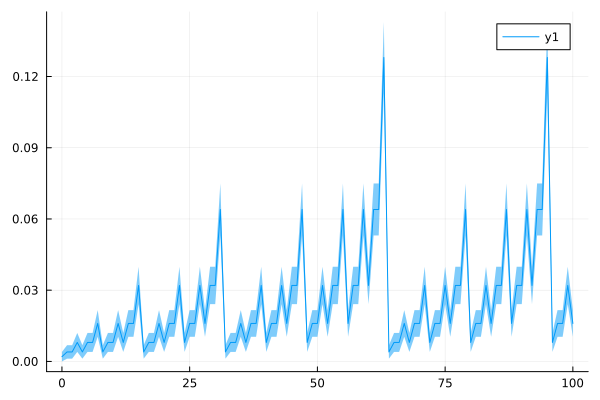

In [133]:
plot(0:T, mean(p_bp), ribbon=std(p_bp)./sqrt(N))

In [129]:
pl_bp = plot(xlabel="time", ylabel="\$\\langle n_i\\rangle\$", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end

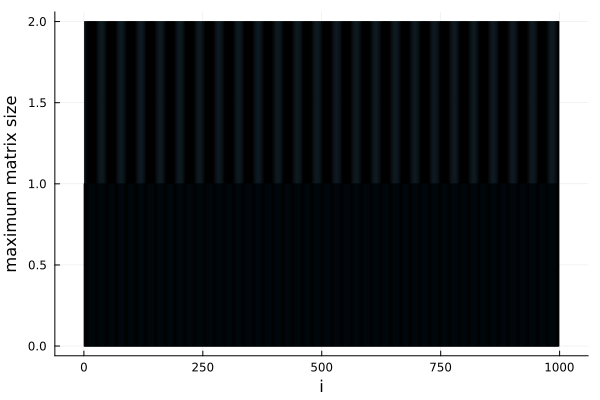

In [131]:
bd = bond_dims.(bp.μ)
bar(maximum.(bd), xlabel="i", ylabel="maximum matrix size", label="")